In [3]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from matplotlib import font_manager
import matplotlib.pyplot as plt
import seaborn as sns

## 데이터 로드

In [4]:
df_seoul_info = pd.read_csv("./data/seoul_info.csv", low_memory=False)
df_seoul_info

# 폰트 경로
font_path = "C:/Windows/Fonts/malgun.ttf"  # Windows 예시
font_name = font_manager.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

##### [참고] 컬럼별 값들 확인
    # 0. NO : 각 레코드별 고유 인덱스 - 결측치 있는 레코드 삭제 후 인덱스 재설정
    # 1. 시군구 : 서울특별시 xx구 xx동 - ' '로 split해서 '구', '동'을 새 컬럼으로 추가
    # 2. 전월세구분 : 100% 전세니까 삭제
    # 3. 전용면적(㎡) : float 형
    # 4. 계약년월 : int 형 숫자 202501 ~ 202512. 전부 2025년에 계약을 한 주택들
    # 5. 계약일 : 필요없으니 삭제
    # 6. 보증금(만원) : 의외로 숫자형이 아님. str -> int 형 변환
    # 7. 월세금(만원) : 전부 '전세'이므로 값이 모두 0. 삭제
    # 8. 건축년도 : Null 값이 들어간 540개 레코드는 삭제. Not Null 값 중 .0 아닌 건 없으니 float -> int 형 변환
    # 9. 도로명 : 필요없으니 삭제
    # 10. 계약기간 : yyyymm~yyyymm 형식의 str. 전부 2025년 혹은 2026년에 시작하는 계약
    # 11. 계약구분 : 신규 약 9만여 개, 갱신 약 7만여 개, '-' 약 1만여 개. '-'는 신고 누락인듯
    # 12. 갱신요구권 사용 : 사용 or '-'. 필요없으니 삭제
    # 13. 종전계약 보증금(만원) : Null 값이 10만여 개 & 전세사기 위험도와 관련이 적은 컬럼이라 생각되어 삭제
    # 14. 종전계약 월세(만원) : Null 값이 10만여 개 & 전세사기 위험도와 관련이 적은 컬럼이라 생각되어 삭제
    # 15. 주택유형 : 아파트 13만 여개, 연립다세대 2만 여개, 오피스텔 1만 5천여 개.
    # 16. key 값 : 1. 시군구 + 9.도로명 형태. 필요없으니 삭제
    # 17. 실거래(만원) : 실거래가
    # 18. 보증금/실거래가 : 1 이상인 값 6500개, 2 이상인 값 300개(?), max값 6.4444(???)

## 컬럼별 결측치 비율 확인

In [5]:
# 컬럼별 결측치 비율 확인
print(df_seoul_info.isna().mean().sort_values(ascending=False))
print(df_seoul_info['종전계약 보증금(만원)'])

종전계약 보증금(만원)    0.586472
종전계약 월세(만원)     0.586472
건축년도            0.003082
전월세구분           0.000000
시군구             0.000000
NO              0.000000
전용면적(㎡)         0.000000
보증금(만원)         0.000000
월세금(만원)         0.000000
계약일             0.000000
계약년월            0.000000
계약기간            0.000000
도로명             0.000000
갱신요구권 사용        0.000000
계약구분            0.000000
주택유형            0.000000
key 값           0.000000
실거래(만원)         0.000000
보증금/실거래가        0.000000
dtype: float64
0         24,000
1            NaN
2         23,000
3            NaN
4         30,000
           ...  
175178       NaN
175179     7,000
175180    26,000
175181    38,000
175182       NaN
Name: 종전계약 보증금(만원), Length: 175183, dtype: object


## 필요한 데이터 가공하기

In [6]:
# 보증금, 실거래가 문자열 → float 변환
df_seoul_info['보증금(만원)'] = df_seoul_info['보증금(만원)'].astype(str).str.replace(",", "").astype(float)
df_seoul_info['실거래(만원)'] = df_seoul_info['실거래(만원)'].astype(str).str.replace(",", "").astype(float)

# 건물 나이 계산
current_year = datetime.now().year
df_seoul_info['건물나이'] = current_year - df_seoul_info['건축년도']

# 전세가율 계산 (보증금 / 실거래가)
df_seoul_info['전세가율'] = df_seoul_info['보증금(만원)'] / df_seoul_info['실거래(만원)']


df = df_seoul_info[['보증금(만원)', '실거래(만원)', '건물나이', '보증금/실거래가', '전세가율', '전용면적(㎡)', '계약년월']].copy()
df = df.dropna()  # 결측치 제거

# 시군구에서 구, 동 추출
df['구'] = df_seoul_info['시군구'].str.split().str[1]
df['동'] = df_seoul_info['시군구'].str.split().str[-1]
df['주택유형'] = df_seoul_info['주택유형']

# 동 + 주택유형별 평균 전세가율
avg_ratio = df.groupby(['동', '주택유형'])['보증금/실거래가'].mean().reset_index()
avg_ratio.rename(columns={'보증금/실거래가': '평균_전세가율'}, inplace=True)


# 병합 후 상대비 계산
df = df.merge(avg_ratio, on=['동', '주택유형'], how='left')
df['전세가율_상대비'] = df['보증금/실거래가'] / df['평균_전세가율']

avg_deposit = df.groupby(['동', '주택유형'])['보증금(만원)'].mean().reset_index()
avg_deposit.rename(columns={'보증금(만원)': '평균보증금(만원)'}, inplace=True)

df = df.merge(avg_deposit, on=['동', '주택유형'], how='left')
df['보증금_상대비'] = df['보증금(만원)'] / df['평균보증금(만원)']

maxratio = df['전세가율_상대비'].dropna().max()
upper = maxratio + 1e-9  # max가 경계값일 때 cut 누락 방지

df['전세가율_구간'] = pd.cut(
    df['전세가율_상대비'],
    bins=[0, 0.90, 1.05, 1.20, upper],
    labels=['안정(<0.90)', '적정(0.90~1.05)', '주의(1.05~1.20)', '위험(>=1.20)'],
    include_lowest=True
)

df['건물나이_구간'] = pd.cut(
    df['건물나이'],
    bins=[0, 10, 25, df['건물나이'].max()],
    labels=['신축(≤10)', '중간(11~25)', '노후(≥26)'],
    include_lowest=True
)

# 이상치 유무 파악

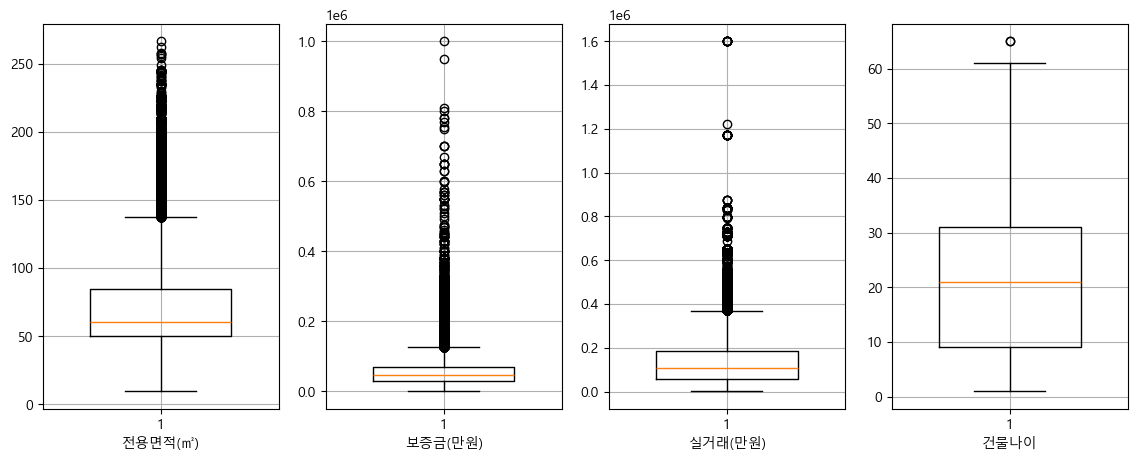

In [7]:
# 이상치 유무 파악
fig, ax = plt.subplots(1, 4, figsize=(14, 5))

ax[0].boxplot([df['전용면적(㎡)']], widths=0.6)
ax[0].set_xlabel('전용면적(㎡)')
ax[0].grid()

ax[1].boxplot([df['보증금(만원)']], widths=0.6)
ax[1].set_xlabel('보증금(만원)')
ax[1].grid()

ax[2].boxplot([df['실거래(만원)']], widths=0.6)
ax[2].set_xlabel('실거래(만원)')
ax[2].grid()

ax[3].boxplot([df['건물나이']], widths=0.6)
ax[3].set_xlabel('건물나이')
ax[3].grid()

plt.show()

In [8]:
# IQR (Interquartile Range): 제3사분위수(Q3)에서 제1사분위수(Q1)를 뺀 값으로, 상자의 길이를 결정
# 수염(Whiskers)의 끝: 보통 Q1 - 1.5 * IQR 와 Q3 + 1.5 * IQR 범위 내의 최소값/최대값
df[df['건물나이'] > 63]['건물나이'].values
# '건축년도'의 이상치 발견 : 1961년 2개

array([65., 65.])

# 시각화

C:\Users\Playdata\AppData\Local\Temp\ipykernel_24540\4001807767.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


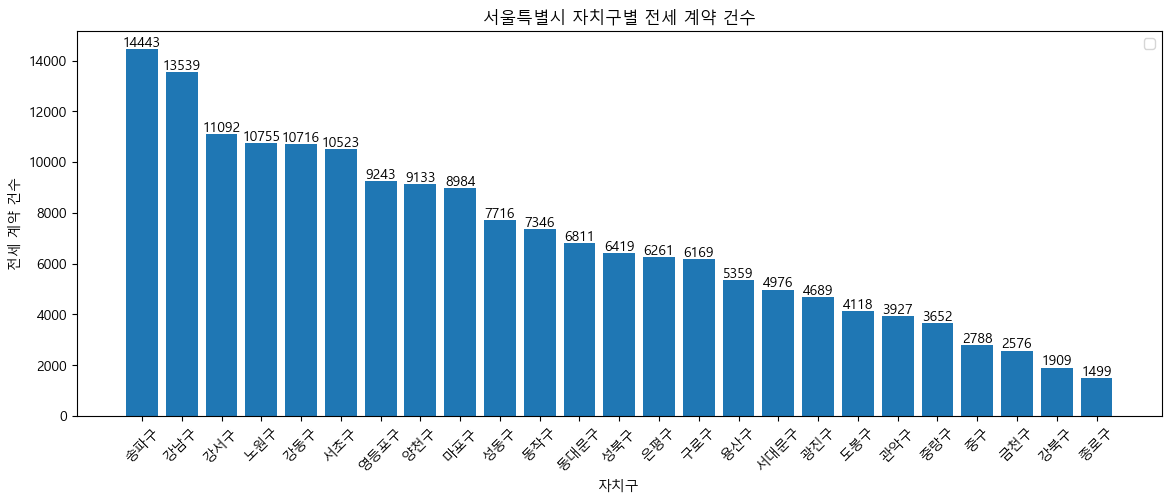

In [9]:
# 1. Bar : 서울특별시 자치구별 전세 계약 건수
fig = plt.figure(figsize=(14, 5))

plt.bar(df.groupby('구')['건물나이'].count().sort_values(ascending=False).index,\
        df.groupby('구')['건물나이'].count().sort_values(ascending=False).values)

for i, val in enumerate(df.groupby('구')['건물나이'].count().sort_values(ascending=False).values):
    # x축 위치, y축 위치, 텍스트, 텍스트 정렬(위치)
    plt.text(i, val + 100, str(val), ha='center')

plt.title('서울특별시 자치구별 전세 계약 건수')
plt.xlabel('자치구')
plt.ylabel('전세 계약 건수')
plt.xticks(rotation=45)
plt.legend()
plt.show()


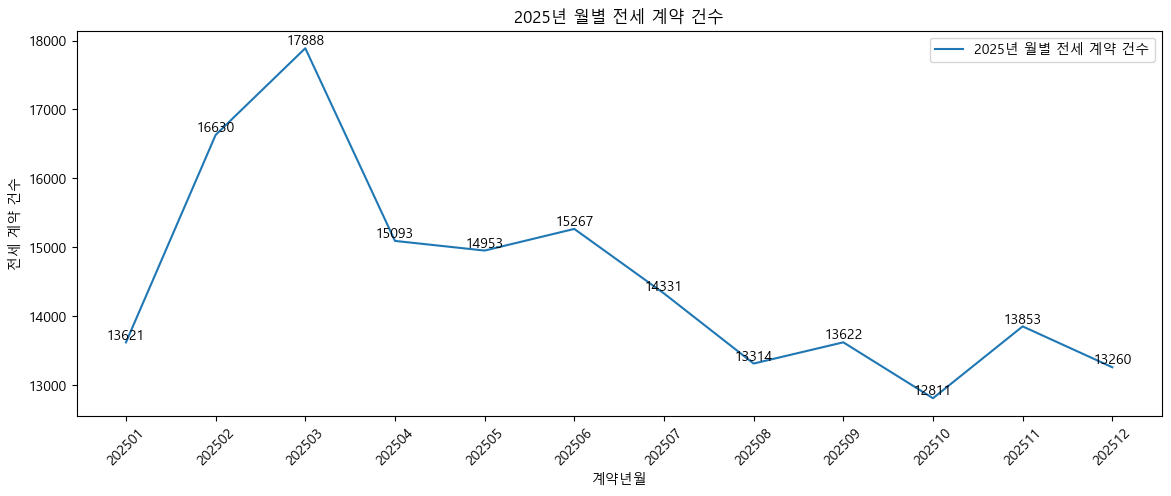

In [10]:
# 2. Line : 2025년 월별 전세 계약 건수
fig = plt.figure(figsize=(14, 5))
plt.plot(df.groupby('계약년월')['건물나이'].count().index.astype(str),\
         df.groupby('계약년월')['건물나이'].count().values, label='2025년 월별 전세 계약 건수')

for i, val in enumerate(df.groupby('계약년월')['건물나이'].count().values):
    # x축 위치, y축 위치, 텍스트, 텍스트 정렬(위치)
    plt.text(i, val + 50, str(val), ha='center')

plt.title('2025년 월별 전세 계약 건수')
plt.xlabel('계약년월')
plt.ylabel('전세 계약 건수')
plt.xticks(
    ticks=range(len(df.groupby('계약년월')['건물나이'].count().index)),
    labels=df.groupby('계약년월')['건물나이'].count().index.astype(str),
    rotation=45,
    # ha='right'
)

plt.legend()
plt.show()

c:\Users\Playdata\miniconda3\envs\mlstudy_env\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()


<Axes: >

c:\Users\Playdata\miniconda3\envs\mlstudy_env\Lib\site-packages\IPython\core\events.py:96: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  func(*args, **kwargs)
c:\Users\Playdata\miniconda3\envs\mlstudy_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


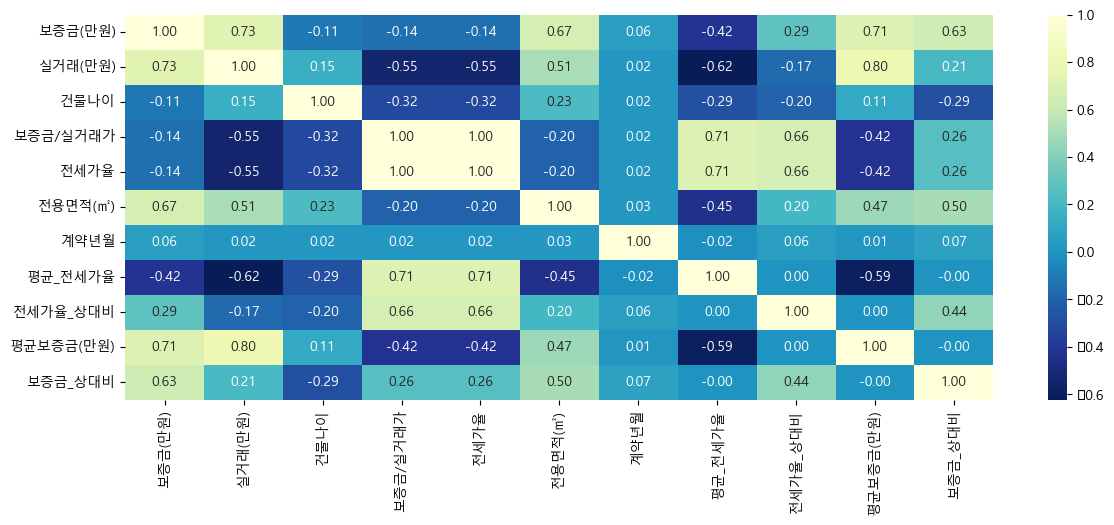

In [11]:
#3. Heatmap : 컬럼 간의 상관 계수 파악
corr_matrix = df.corr(numeric_only=True)

fig = plt.figure(figsize=(14, 5))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='YlGnBu_r')

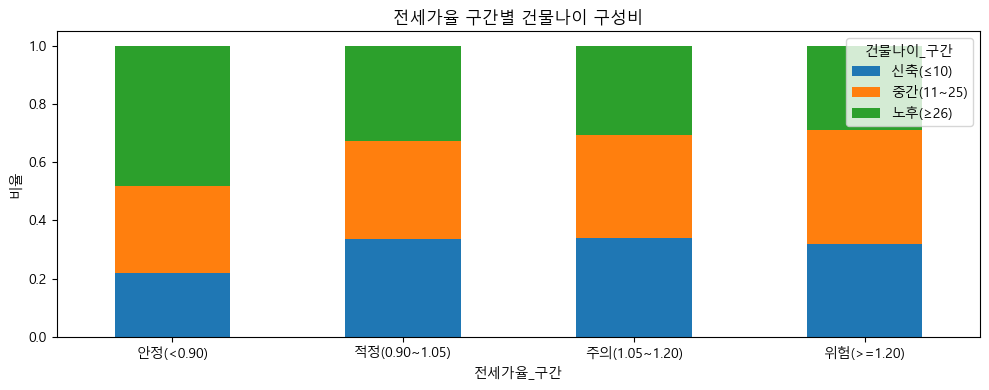

In [12]:
df['건물나이_구간'] = pd.cut(
    df['건물나이'],
    bins=[0, 10, 25, df['건물나이'].max()],
    labels=['신축(≤10)', '중간(11~25)', '노후(≥26)'],
    include_lowest=True
)

age_ratio_by_jeonse = pd.crosstab(  # crosstab은 글자 중복현상 때문에 사용
    df['전세가율_구간'],
    df['건물나이_구간'],
    normalize='index'
).fillna(0)

age_ratio_by_jeonse.plot(kind='bar', stacked=True, figsize=(10,4))
plt.title('전세가율 구간별 건물나이 구성비')
plt.xlabel('전세가율_구간')
plt.ylabel('비율')
plt.xticks(rotation=0)
plt.tight_layout()  # 이것도 시각화 할 때 figsize 늘려놓고 여백 남는거 맞출 때 사용
plt.show()


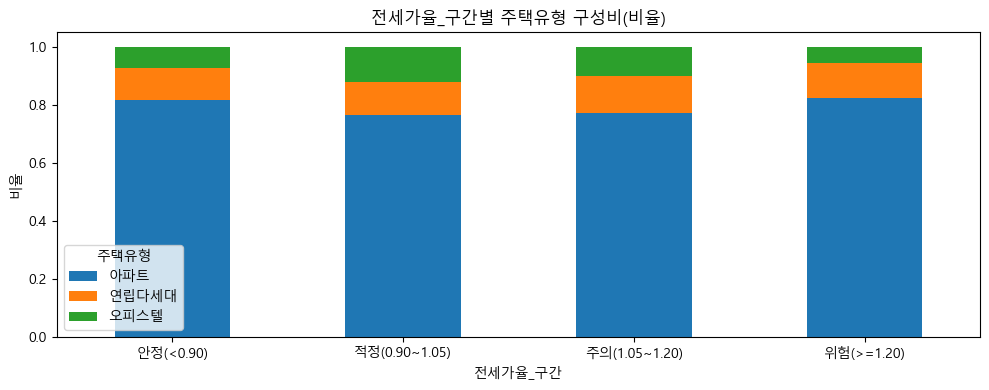

In [13]:
# 3) (시각화) 주택유형

type_ratio_by_bin = pd.crosstab(
    df['전세가율_구간'],
    df['주택유형'],
    normalize='index'   
).fillna(0)

type_ratio_by_bin.plot(kind='bar', stacked=True, figsize=(10,4))
plt.title('전세가율_구간별 주택유형 구성비(비율)')
plt.xlabel('전세가율_구간')
plt.ylabel('비율')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

C:\Users\Playdata\AppData\Local\Temp\ipykernel_24540\3112308304.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_gangnam, x='동', y='평균_전세가율', palette='viridis')


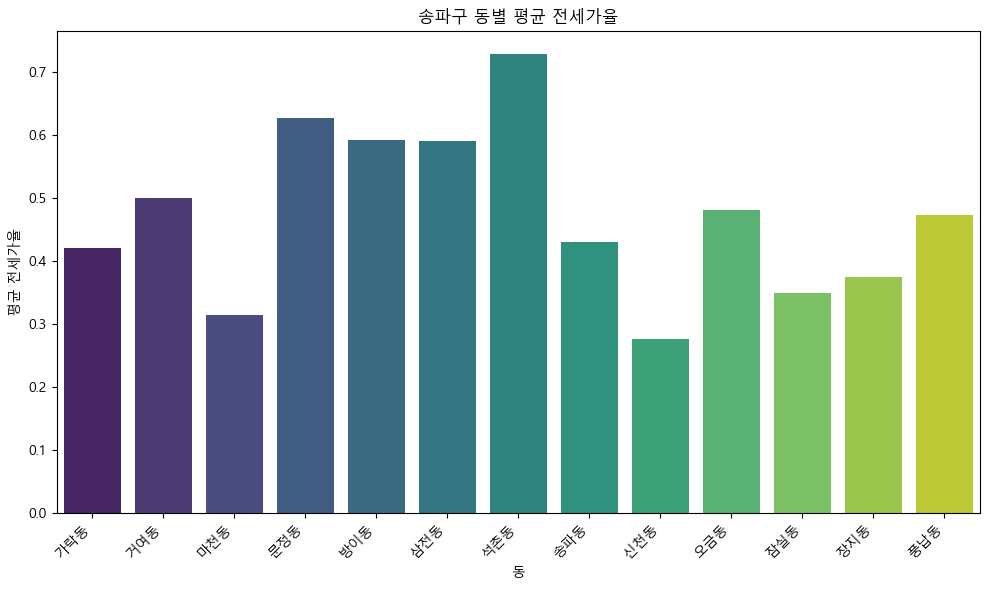

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

df_gangnam = df[df['구'] == '송파구'].groupby('동')['평균_전세가율'].mean().reset_index()

# 그래프
plt.figure(figsize=(10,6))
sns.barplot(data=df_gangnam, x='동', y='평균_전세가율', palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.xlabel("동")
plt.ylabel("평균 전세가율")
plt.title("송파구 동별 평균 전세가율")
plt.tight_layout()
plt.show()

<>:7: SyntaxWarning: invalid escape sequence '\W'
<>:7: SyntaxWarning: invalid escape sequence '\W'
C:\Users\Playdata\AppData\Local\Temp\ipykernel_24540\2810728230.py:7: SyntaxWarning: invalid escape sequence '\W'
  font_path = 'C:\Windows\Fonts\gulim.ttc'


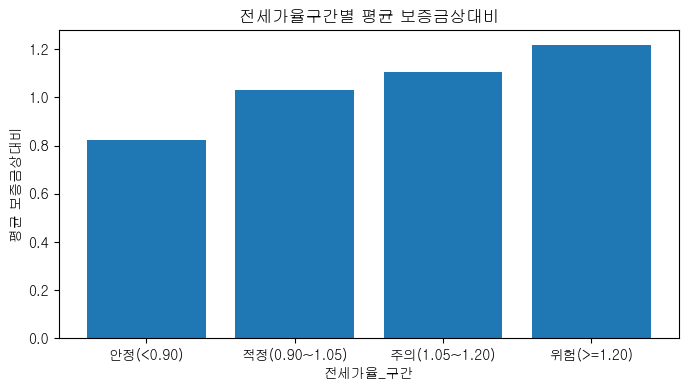

In [15]:
from matplotlib import font_manager as fm
import warnings
import matplotlib.pyplot as plt
import matplotlib

warnings.filterwarnings('ignore')
font_path = 'C:\Windows\Fonts\gulim.ttc'
font = fm.FontProperties(fname=font_path).get_name()
matplotlib.rc('font', family=font)
plt.rcParams['axes.unicode_minus'] = False

risk_trend = (df.groupby('전세가율_구간')[['보증금_상대비', '건물나이']]
                .mean()
                .round(4))

plt.figure(figsize=(8,4))
plt.bar(risk_trend.index.astype(str), risk_trend['보증금_상대비'])
plt.title('전세가율구간별 평균 보증금상대비')
plt.xlabel('전세가율_구간')
plt.ylabel('평균 보증금상대비')
plt.xticks(rotation=0)
plt.show()

In [16]:
#  동-주책 유형별 평균 실거래가 계산

avg_price = df.groupby(['동', '주택유형'])['실거래(만원)'].mean().reset_index().rename(columns={'실거래(만원)' : '동주택유형별_실거래가평균'})

avg_price

avg_price['위험기준_실거래가의70'] = avg_price['동주택유형별_실거래가평균']*0.7

avg_price

df = df.merge(avg_price[['동', '주택유형', '위험기준_실거래가의70']], on=['동', '주택유형'], how='left')

df

df['risk'] = np.where(df['보증금(만원)'] >= df['위험기준_실거래가의70'], 1, 0)

In [17]:
df

,보증금(만원),실거래(만원),건물나이,보증금/실거래가,전세가율,전용면적(㎡),계약년월,구,동,주택유형,평균_전세가율,전세가율_상대비,평균보증금(만원),보증금_상대비,전세가율_구간,건물나이_구간,위험기준_실거래가의70,risk
0,25000.0,20000.0,22.0,1.250000,1.250000,37.49,202512,강남구,역삼동,오피스텔,0.998880,1.251402,25359.829193,0.985811,위험(>=1.20),중간(11~25),18539.610870,1
1,59000.0,74900.0,20.0,0.787717,0.787717,68.04,202512,중구,중림동,오피스텔,0.861672,0.914173,26248.708609,2.247730,적정(0.90~1.05),중간(11~25),22053.708609,1
2,23000.0,17000.0,7.0,1.352941,1.352941,23.10,202512,동대문구,용두동,오피스텔,0.828159,1.633674,17054.820755,1.348592,위험(>=1.20),신축(≤10),15757.924528,1
3,44000.0,53420.0,1.0,0.823662,0.823662,40.42,202512,동대문구,용두동,오피스텔,0.828159,0.994570,17054.820755,2.579916,적정(0.90~1.05),신축(≤10),15757.924528,1
4,31000.0,26000.0,3.0,1.192308,1.192308,27.78,202512,동대문구,신설동,오피스텔,0.961732,1.239750,21727.446809,1.426767,위험(>=1.20),신축(≤10),15873.617021,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174638,11000.0,18500.0,31.0,0.594595,0.594595,83.28,202501,성북구,정릉동,연립다세대,0.799226,0.743963,16811.294118,0.654322,안정(<0.90),노후(≥26),15572.677647,0
174639,7000.0,28000.0,36.0,0.250000,0.250000,42.63,202501,송파구,문정동,연립다세대,0.761575,0.328267,27522.371681,0.254339,안정(<0.90),노후(≥26),26590.707965,0
174640,26000.0,53000.0,12.0,0.490566,0.490566,47.94,202501,광진구,자양동,연립다세대,0.444631,1.103311,27475.077259,0.946312,주의(1.05~1.20),중간(11~25),50821.520408,0
174641,38000.0,45000.0,6.0,0.844444,0.844444,26.62,202501,서초구,방배동,연립다세대,0.596847,1.414842,37409.708520,1.015779,위험(>=1.20),신축(≤10),51885.161435,0


In [18]:
num_1 = 0
num_0 = 0

for i in df['risk'] :
    if i == 1 :
        num_1 = num_1 + 1

    else :
        num_0 = num_0 + 1

print('위험 : ', num_1)
print('안전 : ', num_0)

위험 :  26156
안전 :  148487


<Axes: xlabel='risk', ylabel='전세가율'>

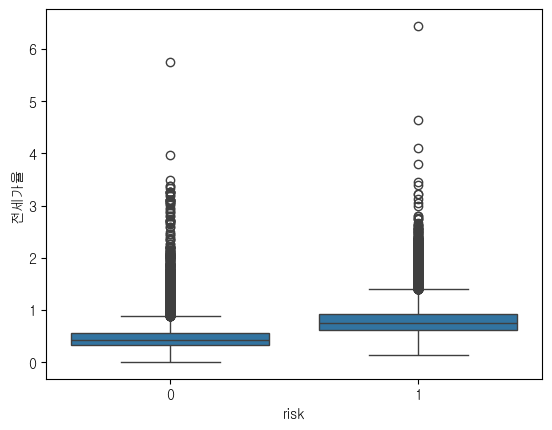

In [19]:
sns.boxplot(x='risk', y='전세가율', data=df)

<Axes: xlabel='건물나이', ylabel='전세가율'>

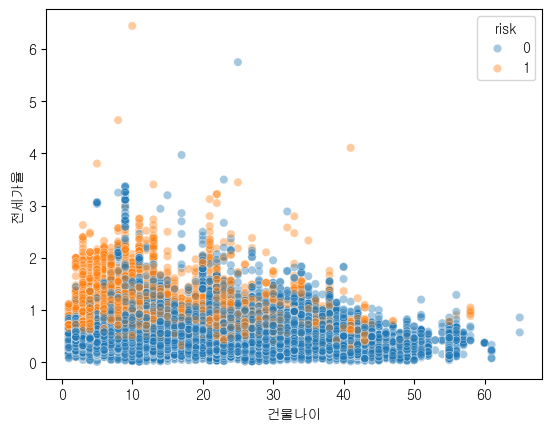

In [20]:
sns.scatterplot(
    data=df,
    x='건물나이',
    y='전세가율',
    hue='risk',
    alpha=0.4
)

In [21]:
df.groupby('주택유형')['risk'].mean().sort_values()

주택유형
아파트      0.077116
연립다세대    0.264792
오피스텔     0.677605
Name: risk, dtype: float64

# Logistic Regression

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = pd.get_dummies(df[['건물나이',
        '전용면적(㎡)',
        '주택유형',        # 인코딩 필요
        '보증금(만원)']],
        columns=['주택유형'],
        drop_first=True
)
y = df['risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train_scl, y_train)

print(lr.coef_, lr.intercept_)

[[-0.96557658  1.41084582 -0.31933825  0.87192569  1.31848601]] [-0.83099726]


In [32]:
from sklearn.metrics import confusion_matrix

y_pred = lr.predict(X_test_scl)

confusion_matrix(y_test, y_pred)

array([[23202,  6579],
       [ 1100,  4048]])

In [33]:
# Recall(위험 탐지율)
recall = 2139 / (2139 + 3009)
recall

0.4155011655011655

In [34]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.78      0.86     29781
           1       0.38      0.79      0.51      5148

    accuracy                           0.78     34929
   macro avg       0.67      0.78      0.69     34929
weighted avg       0.87      0.78      0.81     34929



### 결과 :  
- **“Logistic Regression은 주택유형과 건물나이가 전세 사기 위험에 미치는 방향성을 해석하는 데 유용하였으나, 기본 임계값(0.5) 기준 위험 탐지율은 약 41%로 낮아 실전 적용에는 한계가 있었다. 그리하여 “class_weight='balanced'를 적용한 Logistic Regression은 위험 계약 탐지율을 약 79%까지 향상시켜 전세 사기 조기 경고 모델로서 유의미한 성능을 보였다. 다만 과잉 경고(FP)가 증가하는 한계가 있어, 최종 판단 모델로는 Random Forest를 병행 적용하였다.”**

# Random Forest

In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,           # 트리 개수
    random_state=42,
    class_weight='balanced'
)

rf_clf = rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

confusion_matrix(y_test, y_pred)

array([[29105,   676],
       [  907,  4241]])

In [27]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     29781
           1       0.86      0.82      0.84      5148

    accuracy                           0.95     34929
   macro avg       0.92      0.90      0.91     34929
weighted avg       0.95      0.95      0.95     34929



# 회귀 + 분류
- 동, 구, 면적, 건물나이, 주택유형으로 전세가율이라는 연속적 지표를 먼저 회귀 모델로 예측한 뒤, 정책적 기준에 따라 위험 여부를 분류

In [28]:
X_reg = pd.get_dummies(df[['건물나이', '전용면적(㎡)', '주택유형', '구', '동']],
                       columns = ['주택유형', '구', '동'])

y_reg = df['전세가율']

print(X_reg, y_reg)

        건물나이  전용면적(㎡)  주택유형_아파트  주택유형_연립다세대  주택유형_오피스텔  구_강남구  구_강동구  구_강북구  \
0       22.0    37.49     False       False       True   True  False  False   
1       20.0    68.04     False       False       True  False  False  False   
2        7.0    23.10     False       False       True  False  False  False   
3        1.0    40.42     False       False       True  False  False  False   
4        3.0    27.78     False       False       True  False  False  False   
...      ...      ...       ...         ...        ...    ...    ...    ...   
174638  31.0    83.28     False        True      False  False  False  False   
174639  36.0    42.63     False        True      False  False  False  False   
174640  12.0    47.94     False        True      False  False  False  False   
174641   6.0    26.62     False        True      False  False  False  False   
174642  24.0    32.94     False        True      False  False  False  False   

        구_강서구  구_관악구  ...  동_황학동  동_회기동  동_회현동1가  동

In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error, mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, random_state=42)

rf_reg = RandomForestRegressor(n_estimators=300, random_state=42)

rf_reg.fit(X_train, y_train)

y_pred = rf_reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)           

print(f'MSE : {mse} | RMSE : {rmse} | MAE : {mae} | R2score : {r2}')

KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib

font_path = 'C:\\Windows\\Fonts\\gulim.ttc'
font = fm.FontProperties(fname=font_path).get_name()
matplotlib.rc('font', family=font)

In [ ]:
# 출력문 warning 제거 (무시)
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df_seoul_info = pd.read_csv('./data/seoul_info.csv', encoding='UTF-8')

In [ ]:
df_seoul_info.info()

# 총 19개 컬럼

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175183 entries, 0 to 175182
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   NO            175183 non-null  int64  
 1   시군구           175183 non-null  object 
 2   전월세구분         175183 non-null  object 
 3   전용면적(㎡)       175183 non-null  float64
 4   계약년월          175183 non-null  int64  
 5   계약일           175183 non-null  int64  
 6   보증금(만원)       175183 non-null  object 
 7   월세금(만원)       175183 non-null  int64  
 8   건축년도          174643 non-null  float64
 9   도로명           175183 non-null  object 
 10  계약기간          175183 non-null  object 
 11  계약구분          175183 non-null  object 
 12  갱신요구권 사용      175183 non-null  object 
 13  종전계약 보증금(만원)  72443 non-null   object 
 14  종전계약 월세(만원)   72443 non-null   object 
 15  주택유형          175183 non-null  object 
 16  key 값         175183 non-null  object 
 17  실거래(만원)       175183 non-null  int64  
 18  보증금/

In [ ]:
df_seoul_info.describe()

# 총 175183개 레코드

,NO,전용면적(㎡),계약년월,계약일,월세금(만원),건축년도,실거래(만원),보증금/실거래가
count,175183.000000,175183.000000,175183.000000,175183.000000,175183.0,174643.000000,1.751830e+05,175183.000000
mean,118906.774310,68.352311,202506.276945,16.018130,0.0,2005.065557,1.374950e+05,0.506962
std,76068.106896,28.695875,3.425023,8.497827,0.0,12.452419,1.123773e+05,0.258747
min,1.000000,9.520000,202501.000000,1.000000,0.0,1961.000000,2.000000e+03,0.005882
25%,53736.500000,49.980000,202503.000000,9.000000,0.0,1995.000000,5.700000e+04,0.343147
50%,108205.000000,59.990000,202506.000000,16.000000,0.0,2005.000000,1.065000e+05,0.464286
75%,184709.000000,84.920000,202509.000000,23.000000,0.0,2017.000000,1.830000e+05,0.618182
max,265700.000000,266.520000,202512.000000,31.000000,0.0,2025.000000,1.600000e+06,6.444444


In [ ]:
# '건축년도' 컬럼 내 결측치 처리 : 540개 레코드 삭제 -> 총 174643개 레코드
df_seoul_info = df_seoul_info.drop(df_seoul_info.index[df_seoul_info['건축년도'].isna()])
df_seoul_info['건축년도'].isna().sum()

np.int64(0)

In [ ]:
# '보증금(만원)' : 천 단위 ',' 제거 후 str -> float 형 변환
if type(df_seoul_info['보증금(만원)'].values[0]) != 'float':
    df_seoul_info['보증금(만원)'] = df_seoul_info['보증금(만원)'].str.replace(',', '').astype('float')
df_seoul_info['보증금(만원)'].info()

<class 'pandas.core.series.Series'>
Index: 174643 entries, 0 to 175182
Series name: 보증금(만원)
Non-Null Count   Dtype  
--------------   -----  
174643 non-null  float64
dtypes: float64(1)
memory usage: 2.7 MB


In [ ]:
# '시군구' : 값에서 '구'만 분리해 '구' 컬럼 추가 후, 자치구별로 라벨 인코딩 진행한 '구_encoder' 컬럼 추가
from sklearn.preprocessing import LabelEncoder

df_seoul_info['구'] = df_seoul_info['시군구'].str.split(' ').str[1]

encoder = LabelEncoder()
df_seoul_info['구_encoder'] = encoder.fit_transform(df_seoul_info['구'])

df_seoul_info[['구', '구_encoder']].value_counts()

구     구_encoder
송파구   17           14443
강남구   0            13539
강서구   3            11092
노원구   8            10755
강동구   1            10716
서초구   14           10523
영등포구  19            9243
양천구   18            9133
마포구   12            8984
성동구   15            7716
동작구   11            7346
동대문구  10            6811
성북구   16            6419
은평구   21            6261
구로구   6             6169
용산구   20            5359
서대문구  13            4976
광진구   5             4689
도봉구   9             4118
관악구   4             3927
중랑구   24            3652
중구    23            2788
금천구   7             2576
강북구   2             1909
종로구   22            1499
Name: count, dtype: int64

In [ ]:
# '계약구분' : 계약 형태(신규, 갱신)에 따라 라벨 인코딩 진행한 '계약구분_encoder' 컬럼 추가
encoder = LabelEncoder()
df_seoul_info['계약구분_encoder'] = encoder.fit_transform(df_seoul_info['계약구분'])

df_seoul_info[['계약구분', '계약구분_encoder']].value_counts()

계약구분  계약구분_encoder
신규    2               92623
갱신    1               72229
-     0                9791
Name: count, dtype: int64

In [ ]:
# '주택유형' : 주택 유형(아파트, 연립다세대, 오피스텔)에 따라 라벨 인코딩 진행한 '주택유형_encoder' 컬럼 추가
encoder = LabelEncoder()
df_seoul_info['주택유형_encoder'] = encoder.fit_transform(df_seoul_info['주택유형'])

df_seoul_info[['주택유형', '주택유형_encoder']].value_counts()

주택유형   주택유형_encoder
아파트    0               139478
연립다세대  1                20416
오피스텔   2                14749
Name: count, dtype: int64

In [ ]:
# X 데이터
df_seoul_info_data = df_seoul_info[['구_encoder', '전용면적(㎡)', '계약년월', '보증금(만원)', '계약구분_encoder']]
df_seoul_info_data.describe()

,구_encoder,전용면적(㎡),계약년월,보증금(만원),계약구분_encoder
count,174643.000000,174643.000000,174643.000000,174643.000000,174643.000000
mean,11.230006,68.428452,202506.277515,53923.609002,1.474293
std,6.963564,28.700936,3.424714,36352.629650,0.601221
min,0.000000,9.520000,202501.000000,500.000000,0.000000
25%,5.000000,50.030000,202503.000000,29000.000000,1.000000
50%,12.000000,59.990000,202506.000000,47250.000000,2.000000
75%,17.000000,84.920000,202509.000000,68250.000000,2.000000
max,24.000000,266.520000,202512.000000,1000000.000000,2.000000


In [ ]:
# y 데이터로 쓸 파생 변수 컬럼이 필요
# - 전세사기 위험도에 영향을 주는 요인들(전세가율, 주택유형, 건물 신축 여부)에 대해 위험도 점수 부여
# - 위험도 점수 총합에 대해 '안전', '주의'로 나누고 이를 0 / 1로 표현

# 1. 각 매물별 '전세가율'에 따른 위험도 점수 계산을 위해 '위험도_전세가율' 컬럼 추가
df_seoul_info['위험도_전세가율'] = np.select(
    [df_seoul_info['보증금/실거래가'] >= 1.1, df_seoul_info['보증금/실거래가'] >= 1.0,\
     df_seoul_info['보증금/실거래가'] >= 0.9, df_seoul_info['보증금/실거래가'] >= 0.8,\
     df_seoul_info['보증금/실거래가'] >= 0.7], 
    [5, 4, 3, 2, 1],
    default=0
)

df_seoul_info['위험도_전세가율'].value_counts()

위험도_전세가율
0    144655
1     10477
2      7381
3      5389
5      3851
4      2890
Name: count, dtype: int64

In [ ]:
# 2. 각 매물별 '주택유형'에 따른 위험도 점수 계산을 위해 '위험도_주택유형' 컬럼 추가
df_seoul_info['위험도_주택유형'] = np.select(
    [df_seoul_info['주택유형'] != '아파트'],
    [1],
    default=0
)

df_seoul_info['위험도_주택유형'].value_counts()

위험도_주택유형
0    139478
1     35165
Name: count, dtype: int64

In [ ]:
# 3. 각 매물별 '건물 신축 여부'에 따른 위험도 점수 계산을 위해 '위험도_건축년도' 컬럼 추가
df_seoul_info['위험도_건축년도'] = np.select(
    [(2025 - df_seoul_info['건축년도']) <= 2, (2025 - df_seoul_info['건축년도']) <= 5], 
    [2, 1],
    default=0
)

df_seoul_info['위험도_건축년도'].value_counts()

위험도_건축년도
0    149485
1     16704
2      8454
Name: count, dtype: int64

In [ ]:
# 4. 위 3가지 위험도 점수에 대해 총합을 구하는 '위험도_총합' 컬럼 추가
df_seoul_info['위험도_총합'] = df_seoul_info['위험도_전세가율'] + df_seoul_info['위험도_주택유형'] + df_seoul_info['위험도_건축년도']

# '위험도_총합' 컬럼의 값을 범주에 따라 '안전'(0), '주의'(1)로 나누는 '위험도_총합_분류' 컬럼 추가
df_seoul_info['위험도_총합_분류'] = np.select(
    [df_seoul_info['위험도_총합'] >= 1], 
    [1],
    default=0
)

df_seoul_info['위험도_총합_분류'].value_counts()

위험도_총합_분류
0    114983
1     59660
Name: count, dtype: int64

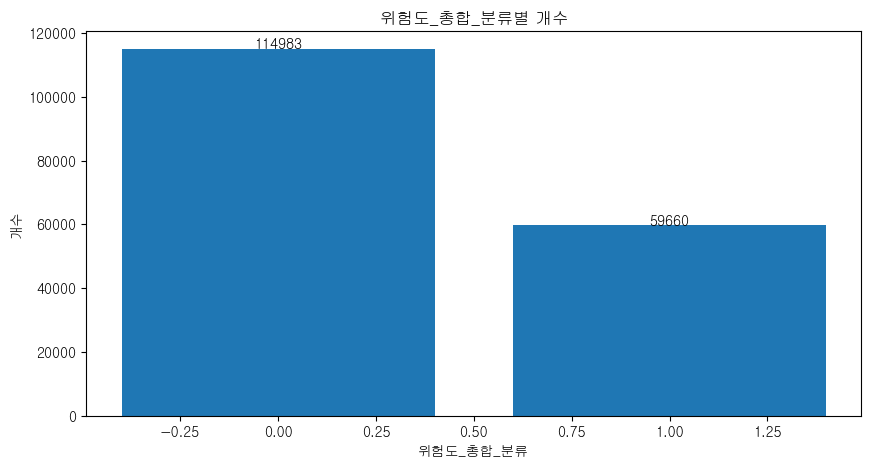

In [ ]:
# Bar : 위험도_총합 수치별 개수
fig = plt.figure(figsize=(10, 5))

plt.bar(df_seoul_info['위험도_총합_분류'].value_counts().index,\
        df_seoul_info['위험도_총합_분류'].value_counts().values)

for i, val in enumerate(df_seoul_info['위험도_총합_분류'].value_counts().values):
    # x축 위치, y축 위치, 텍스트, 텍스트 정렬(위치)
    plt.text(i, val + 100, str(val), ha='center')

plt.title('위험도_총합_분류별 개수')
plt.xlabel('위험도_총합_분류')
plt.ylabel('개수')
plt.show()

In [ ]:
# y 데이터
df_seoul_info_target = df_seoul_info['위험도_총합_분류']
df_seoul_info_target.value_counts()

위험도_총합_분류
0    114983
1     59660
Name: count, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_seoul_info_data, df_seoul_info_target, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((130982, 5), (43661, 5), (130982,), (43661,))

##### 01_overview

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
print('모델명 : KNN ----------------------------')
kn = KNeighborsClassifier()

kn.fit(X_train, y_train)
print('학습 데이터 점수 :', kn.score(X_train, y_train))
print('평가 데이터 점수 :', kn.score(X_test, y_test))

모델명 : KNN ----------------------------
학습 데이터 점수 : 0.8631491349956483
평가 데이터 점수 : 0.8077689471152745


In [ ]:
from sklearn.preprocessing import StandardScaler
print('모델명 : KNN (정규화 진행) ----------------')
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

kn.fit(X_train_scaled, y_train)
print('학습 데이터 점수 :', kn.score(X_train_scaled, y_train))
print('평가 데이터 점수 :', kn.score(X_test_scaled, y_test))

모델명 : KNN (정규화 진행) ----------------
학습 데이터 점수 : 0.8750591684353576
평가 데이터 점수 : 0.8255651496759121


In [ ]:
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
print('모델명 : KNN (차원 축소) -----------------')
pca = PCA(n_components=2)

pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)

X_train_pca = pd.DataFrame(X_train_pca, columns=['pca_col1', 'pca_col2'])

# 원본 데이터 학습 및 평가 (교차검증)
kn = KNeighborsClassifier()
scores = cross_val_score(kn, X_train_scaled, y_train, cv=5)
print(f'원본 데이터 평가: {np.mean(scores)}')

# PCA 데이터 학습 및 평가 (교차검증)
scores = cross_val_score(kn, X_train_pca[['pca_col1', 'pca_col2']], y_train, cv=5)
print(f'PCA 데이터 평가: {np.mean(scores)}')

모델명 : KNN (차원 축소) -----------------
원본 데이터 평가: 0.8216778011896226
PCA 데이터 평가: 0.7658533152318829


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, precision_score, recall_score
print('모델명 : KNN (하이퍼 파라미터 튜닝) --------')
kn = KNeighborsClassifier()

params = {
    'n_neighbors': range(1, 13, 2)
}
grid = GridSearchCV(kn, params, scoring='accuracy', cv=5)
grid.fit(X_train_scaled, y_train)

print('최적의 하이퍼 파라미터 :', grid.best_params_)
print('학습 데이터 점수 :', grid.best_estimator_.score(X_train_scaled, y_train))
print('평가 데이터 점수 :', grid.best_estimator_.score(X_test_scaled, y_test))
print('--------------------------------------')
y_pred = grid.best_estimator_.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

모델명 : KNN (하이퍼 파라미터 튜닝) --------
최적의 하이퍼 파라미터 : {'n_neighbors': 5}
학습 데이터 점수 : 0.8750591684353576
평가 데이터 점수 : 0.8255651496759121
--------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.91      0.87     28710
           1       0.80      0.66      0.72     14951

    accuracy                           0.83     43661
   macro avg       0.82      0.79      0.80     43661
weighted avg       0.82      0.83      0.82     43661



In [ ]:
# 실제 예측?

result = (y_test == y_pred).astype(int)

print('test 개수 43661개 중 일치 개수 :', result.sum(), '| 일치 확률 :' , round(result.sum() / len(y_test), 4) * 100, '%')

test 개수 43661개 중 일치 개수 : 36045 | 일치 확률 : 82.56 %


In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(include_bias=False, degree=2)
poly.fit(df_seoul_info_data)
df_seoul_info_poly = poly.transform(df_seoul_info_data)

X_train, X_test, y_train, y_test = train_test_split(df_seoul_info_poly, df_seoul_info_target, random_state=42)

print('모델명 : KNN (Polynomial) -------------')
kn = KNeighborsClassifier()

kn.fit(X_train, y_train)
print('학습 데이터 점수 :', kn.score(X_train, y_train))
print('평가 데이터 점수 :', kn.score(X_test, y_test))
print('--------------------------------------')
y_pred = kn.predict(X_test)
print(classification_report(y_test, y_pred))
print(df_seoul_info_poly.shape)

모델명 : KNN (Polynomial) -------------
학습 데이터 점수 : 0.8573239071017392
평가 데이터 점수 : 0.8016078422390692
--------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.90      0.86     28710
           1       0.76      0.61      0.68     14951

    accuracy                           0.80     43661
   macro avg       0.79      0.76      0.77     43661
weighted avg       0.80      0.80      0.80     43661

(174643, 20)


In [ ]:
from sklearn.neighbors import KNeighborsRegressor
print('모델명 : KNN 회귀 -----------------------')
kn = KNeighborsRegressor()

kn.fit(X_train, y_train)
print('학습 데이터 점수 :', kn.score(X_train, y_train))
print('평가 데이터 점수 :', kn.score(X_test, y_test))

모델명 : KNN 회귀 -----------------------
학습 데이터 점수 : 0.6162490860780101
평가 데이터 점수 : 0.4119789125527027


In [ ]:
print('모델명 : KNN 회귀 (정규화 진행) -----------')

kn.fit(X_train_scaled, y_train)
print('학습 데이터 점수 :', kn.score(X_train_scaled, y_train))
print('평가 데이터 점수 :', kn.score(X_test_scaled, y_test))

모델명 : KNN 회귀 (정규화 진행) -----------
학습 데이터 점수 : 0.651686703350439
평가 데이터 점수 : 0.4606523326155808


##### 03_regression

In [ ]:
from sklearn.linear_model import LinearRegression
print('모델명 : 선형 회귀 -----------------------')

lr = LinearRegression()
lr.fit(X_train, y_train)
print('학습 데이터 점수 :', lr.score(X_train, y_train))
print('평가 데이터 점수 :', lr.score(X_test, y_test))

모델명 : 선형 회귀 -----------------------
학습 데이터 점수 : 0.2029012317326817
평가 데이터 점수 : 0.20269224522322082


In [ ]:
print('모델명 : 선형 회귀 (정규화 진행) ----------')

lr.fit(X_train_scaled, y_train)
print('학습 데이터 점수 :', lr.score(X_train_scaled, y_train))
print('평가 데이터 점수 :', lr.score(X_test_scaled, y_test))

모델명 : 선형 회귀 (정규화 진행) ----------
학습 데이터 점수 : 0.20290123173268237
평가 데이터 점수 : 0.20269759183983438


In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score
print('모델명 : Ridge 회귀 --------------------')
reg_l2 = Ridge()

reg_l2.fit(X_train, y_train)
print('학습 데이터 점수 :', reg_l2.score(X_train, y_train))
print('평가 데이터 점수 :', reg_l2.score(X_test, y_test))
print('--------------------------------------')

y_pred = reg_l2.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse} | RMSE: {rmse} | MAE: {mae} | R2score: {r2}')

모델명 : Ridge 회귀 --------------------
학습 데이터 점수 : 0.20290123172706775
평가 데이터 점수 : 0.20269222843686507
--------------------------------------
MSE: 0.17148758102625544 | RMSE: 0.41411059033337394 | MAE: 0.3603681761842551 | R2score: 0.20269222843686507


In [ ]:
from sklearn.linear_model import Lasso
print('모델명 : Lasso 회귀 --------------------')
reg_l1 = Lasso(alpha=1)

reg_l1.fit(X_train, y_train)
print('학습 데이터 점수 :', reg_l1.score(X_train, y_train))
print('평가 데이터 점수 :', reg_l1.score(X_test, y_test))
print('--------------------------------------')

y_pred = reg_l1.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse} | RMSE: {rmse} | MAE: {mae} | R2score: {r2}')

모델명 : Lasso 회귀 --------------------
학습 데이터 점수 : 0.1758806956112129
평가 데이터 점수 : 0.17329871673643704
--------------------------------------
MSE: 0.17780963431502636 | RMSE: 0.4216747968696094 | MAE: 0.3743857039075229 | R2score: 0.17329871673643704


In [ ]:
from sklearn.linear_model import ElasticNet
print('모델명 : ElasticNet 회귀 ---------------')
reg_ela = ElasticNet(alpha=1, l1_ratio=0.5)

reg_ela.fit(X_train, y_train)
print('학습 데이터 점수 :', reg_ela.score(X_train, y_train))
print('평가 데이터 점수 :', reg_ela.score(X_test, y_test))

모델명 : ElasticNet 회귀 ---------------
학습 데이터 점수 : 0.183483328061682
평가 데이터 점수 : 0.1812307205129492


##### 04_classification

In [ ]:
from sklearn.linear_model import LogisticRegression
print('모델명 : 로지스틱 회귀 ------------------')
lr_clf = LogisticRegression()

lr_clf.fit(X_train_scaled, y_train)
print('학습 데이터 점수 :', lr_clf.score(X_train_scaled, y_train))
print('평가 데이터 점수 :', lr_clf.score(X_test_scaled, y_test))
print('--------------------------------------')
print(df_seoul_info_data.columns)
print('가중치 :', lr_clf.coef_, '편향 :', lr_clf.intercept_)

모델명 : 로지스틱 회귀 ------------------
학습 데이터 점수 : 0.8048281443251745
평가 데이터 점수 : 0.8042875793041845
--------------------------------------
Index(['구_encoder', '전용면적(㎡)', '계약년월', '보증금(만원)', '계약구분_encoder'], dtype='object')
가중치 : [[ 0.17776637 -1.53833889 -0.01513715  0.35790267  0.28185365]] 편향 : [-1.07958789]


In [ ]:
from sklearn.tree import DecisionTreeClassifier
print('모델명 : 결정 트리 ----------------------')
dt_clf = DecisionTreeClassifier(random_state=42, max_depth=30)

dt_clf.fit(X_train, y_train)
print('학습 데이터 점수 :', dt_clf.score(X_train, y_train))
print('평가 데이터 점수 :', dt_clf.score(X_test, y_test))
print('--------------------------------------')
print('feature_importances_ :', dt_clf.feature_importances_)

모델명 : 결정 트리 ----------------------
학습 데이터 점수 : 0.9973660502969873
평가 데이터 점수 : 0.9180733377613889
--------------------------------------
feature_importances_ : [0.13390844 0.64825842 0.04967409 0.15644394 0.0117151 ]


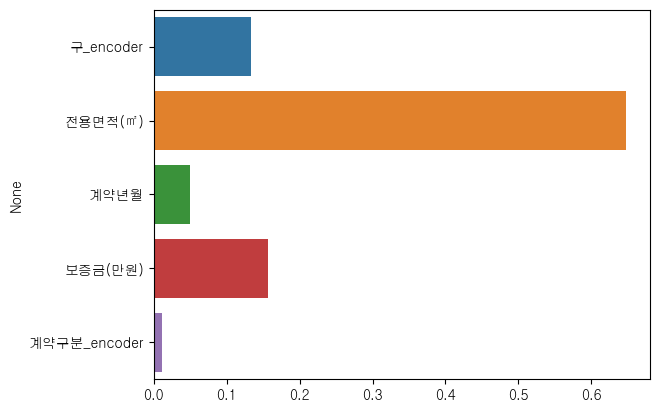

In [ ]:
# 특성 중요도 시각화
sns.barplot(x=dt_clf.feature_importances_, y=df_seoul_info_data.columns, hue=df_seoul_info_data.columns)
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeRegressor
print('모델명 : 결정 트리 회귀 ------------------')
dt_reg = DecisionTreeRegressor(random_state=42, max_depth=30)

dt_reg.fit(X_train, y_train)
print('학습 데이터 점수 :', dt_reg.score(X_train, y_train))
print('평가 데이터 점수 :', dt_reg.score(X_test, y_test))

모델명 : 결정 트리 회귀 ------------------
학습 데이터 점수 : 0.9922162267573794
평가 데이터 점수 : 0.6202136730607819


In [ ]:
from sklearn.svm import SVC
print('모델명 : 서포트 벡터 머신 (분류) ---------')
svm_clf = SVC(kernel='linear')      # rbf, poly

svm_clf.fit(X_train, y_train)
print('학습 데이터 점수 :', svm_clf.score(X_train, y_train))
print('평가 데이터 점수 :', svm_clf.score(X_test, y_test))

# 멈추지 않고 돌아가는 중...

모델명 : 서포트 벡터 머신 (분류) ---------


In [ ]:
from sklearn.svm import SVR
print('모델명 : 서포트 벡터 머신 (회귀) ---------')
svm_reg = SVR(kernel='rbf')

svm_reg.fit(X_train, y_train)
print('학습 데이터 점수 :', svm_reg.score(X_train, y_train))
print('평가 데이터 점수 :', svm_reg.score(X_test, y_test))

# 멈추지 않고 돌아가는 중...

모델명 : 서포트 벡터 머신 (회귀) ---------


##### 05_ensemble

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
print('모델명 : hard voting ------------------')
knn_clf = KNeighborsClassifier()
lr_clf = LogisticRegression()
dt_clf = DecisionTreeClassifier()

voting_clf = VotingClassifier(
    estimators=[
        ('knn_clf', knn_clf),
        ('lr_clf', lr_clf),
        ('dt_clf', dt_clf)
    ],
    voting='hard'
)

voting_clf.fit(X_train, y_train)

y_pred_train = voting_clf.predict(X_train)
y_pred_test = voting_clf.predict(X_test)

print('학습 데이터 정확도 :', accuracy_score(y_train, y_pred_train))
print('평가 데이터 정확도 :', accuracy_score(y_test, y_pred_test))

모델명 : hard voting ------------------
학습 데이터 정확도 : 0.9127819089645905
평가 데이터 정확도 : 0.8742813952955727


In [ ]:
print('모델명 : soft voting ------------------')

voting_clf = VotingClassifier(
    estimators=[
        ('knn_clf', knn_clf),
        ('lr_clf', lr_clf),
        ('dt_clf', dt_clf)
    ],
    voting='soft'
)

voting_clf.fit(X_train, y_train)

y_pred_train = voting_clf.predict(X_train)
y_pred_test = voting_clf.predict(X_test)

print('학습 데이터 정확도 :', accuracy_score(y_train, y_pred_train))
print('평가 데이터 정확도 :', accuracy_score(y_test, y_pred_test))

모델명 : soft voting ------------------
학습 데이터 정확도 : 0.9662243667068757
평가 데이터 정확도 : 0.9039188291610362


In [ ]:
from sklearn.ensemble import RandomForestClassifier
print('모델명 : Random Forest -----------------')
rf_clf = RandomForestClassifier(max_depth=30, random_state=42)

rf_clf.fit(X_train, y_train)
print('학습 데이터 점수 :', rf_clf.score(X_train, y_train))
print('평가 데이터 점수 :', rf_clf.score(X_test, y_test))

모델명 : Random Forest ----------------
학습 데이터 점수 : 0.9983051106258876
평가 데이터 점수 : 0.9254483406243559


In [ ]:
# 특성 중요도 확인 가능
rf_clf.feature_importances_

feat_impt_ser = pd.Series(rf_clf.feature_importances_, index=df_seoul_info_data.columns).sort_values(ascending=False)
feat_impt_ser

전용면적(㎡)         0.632554
보증금(만원)         0.232826
구_encoder       0.099018
계약구분_encoder    0.033825
계약년월            0.001777
dtype: float64

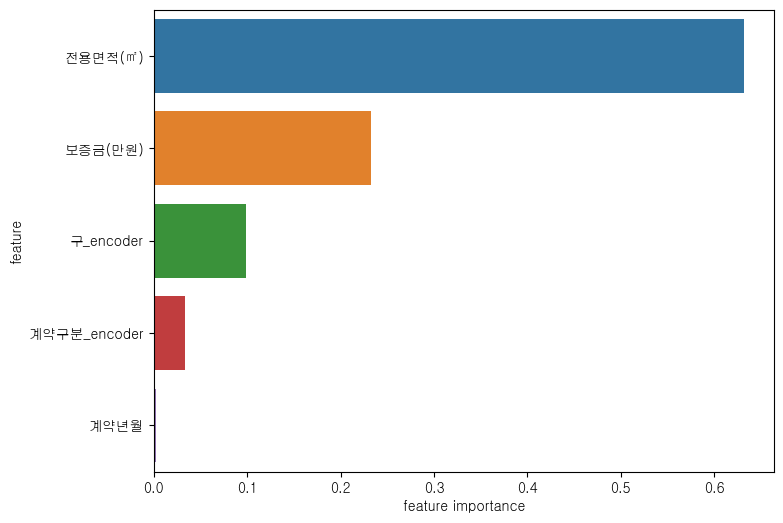

In [ ]:
# 특성 중요도 시각화
plt.figure(figsize=(8, 6))
sns.barplot(
    x=feat_impt_ser,
    y=feat_impt_ser.index,
    hue=feat_impt_ser.index,
)
plt.xlabel('feature importance')
plt.ylabel('feature')
plt.show()

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
print('모델명 : Gradient Boosting ------------')
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5)

gb_clf.fit(X_train, y_train)
y_pred_train = gb_clf.predict(X_train)
y_pred_test = gb_clf.predict(X_test)
print('학습 데이터 정확도 :', accuracy_score(y_train, y_pred_train))
print('평가 데이터 정확도 :', accuracy_score(y_test, y_pred_test))

모델명 : Gradient Boosting ------------
학습 데이터 정확도 : 0.8661419126292162
평가 데이터 정확도 : 0.8629898536451295


In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
print('모델명 : Hist Gradient Boosting -------')
hist_gb_clf = HistGradientBoostingClassifier(
    learning_rate=0.1,
    max_depth=3,
    max_bins=255,           # 255개의 구간으로 나누어 처리 (1개는 결측치 전용)
    early_stopping=True,    # 학습 반복 중 '일정 횟수' 이상 성능 향상이 없으면 학습 종료
    n_iter_no_change=5      # '일정 횟수' (기본값: 10)
)

hist_gb_clf.fit(X_train, y_train)

y_pred_train = hist_gb_clf.predict(X_train)
y_pred_test = hist_gb_clf.predict(X_test)
print('학습 데이터 정확도 :', accuracy_score(y_train, y_pred_train))
print('평가 데이터 정확도 :', accuracy_score(y_test, y_pred_test))

모델명 : Hist Gradient Boosting -------
학습 데이터 정확도 : 0.8350154983127452
평가 데이터 정확도 : 0.8339479169052473


In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
print('모델명 : Hist Gradient Boosting 회귀 ---')
hist_gb_reg = HistGradientBoostingRegressor(
    max_iter=200,
    max_depth=1,
    learning_rate=0.1,
    random_state=42,
    l2_regularization=0.0,
    min_samples_leaf=20,
    max_bins=127
)

hist_gb_reg.fit(X_train, y_train)

y_pred_train = hist_gb_reg.predict(X_train)
y_pred_test = hist_gb_reg.predict(X_test)

train_mse = mean_squared_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)
print('학습 데이터 MSE :', train_mse, '평가 데이터 MSE :', test_mse)
print('학습 데이터 R2 :', train_r2, '평가 데이터 R2 :', test_r2)

모델명 : Hist Gradient Boosting 회귀 ---
학습 데이터 MSE : 0.1390493940392367 평가 데이터 MSE : 0.13948077517552956
학습 데이터 R2 : 0.35273759495716295 평가 데이터 R2 : 0.35150344202433215


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score
print('모델명 : XGBoost ----------------------')
xgb_clf = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

xgb_clf.fit(X_train, y_train)
y_pred_train = xgb_clf.predict(X_train)
y_pred_test = xgb_clf.predict(X_test)

print('학습 데이터 정확도 :', accuracy_score(y_train, y_pred_train))
print('평가 데이터 정확도 :', accuracy_score(y_test, y_pred_test))
print('학습 데이터 정밀도 :', precision_score(y_train, y_pred_train))
print('평가 데이터 정밀도 :', precision_score(y_test, y_pred_test))
print('학습 데이터 재현율 :', recall_score(y_train, y_pred_train))
print('평가 데이터 재현율 :', recall_score(y_test, y_pred_test))
print('--------------------------------------')
print(classification_report(y_test, y_pred_test))

모델명 : XGBoost ----------------------
학습 데이터 정확도 : 0.8344047273671191
평가 데이터 정확도 : 0.8321614255285037
학습 데이터 정밀도 : 0.8922400572538596
평가 데이터 정밀도 : 0.8891271056661562
학습 데이터 재현율 : 0.5855867946051131
평가 데이터 재현율 : 0.5825028426192228
--------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.96      0.88     28710
           1       0.89      0.58      0.70     14951

    accuracy                           0.83     43661
   macro avg       0.85      0.77      0.79     43661
weighted avg       0.84      0.83      0.82     43661



In [ ]:
xgb_clf = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    early_stopping_rounds=10,   # 성능이 일정 횟수 이상 향상되지 않으면 조기종료
    eval_metric='logloss'       # 검증 방식 (손실함수)
)

# 검증 데이터 분리
X_tr, X_eval, y_tr, y_eval = train_test_split(X_train, y_train, random_state=42)
eval_set = [(X_tr, y_tr), (X_eval, y_eval)]

xgb_clf.fit(X_tr, y_tr, eval_set=eval_set)

[0]	validation_0-logloss:0.58525	validation_1-logloss:0.58279
[1]	validation_0-logloss:0.55731	validation_1-logloss:0.55577
[2]	validation_0-logloss:0.53352	validation_1-logloss:0.53257
[3]	validation_0-logloss:0.51475	validation_1-logloss:0.51438
[4]	validation_0-logloss:0.49984	validation_1-logloss:0.49989
[5]	validation_0-logloss:0.48557	validation_1-logloss:0.48602
[6]	validation_0-logloss:0.47479	validation_1-logloss:0.47551
[7]	validation_0-logloss:0.46502	validation_1-logloss:0.46600
[8]	validation_0-logloss:0.45714	validation_1-logloss:0.45845
[9]	validation_0-logloss:0.44970	validation_1-logloss:0.45119
[10]	validation_0-logloss:0.44353	validation_1-logloss:0.44521
[11]	validation_0-logloss:0.43770	validation_1-logloss:0.43957
[12]	validation_0-logloss:0.43296	validation_1-logloss:0.43504
[13]	validation_0-logloss:0.42829	validation_1-logloss:0.43047
[14]	validation_0-logloss:0.42435	validation_1-logloss:0.42670
[15]	validation_0-logloss:0.42048	validation_1-logloss:0.42299
[1

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",10
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes fr

In [ ]:
print('학습 데이터 점수 :', xgb_clf.score(X_train, y_train))
print('평가 데이터 점수 :', xgb_clf.score(X_test, y_test))

학습 데이터 점수 : 0.8563161350414561
평가 데이터 점수 : 0.8547216050937908


In [ ]:
from sklearn.model_selection import GridSearchCV
print('모델명 : XGBoost (하이퍼 파라미터 튜닝) --')
xgb_clf = XGBClassifier(
    # n_estimators = 600,
    max_depth = 21,
    learning_rate=0.23,
    random_state=42
)

params = {
    'n_estimators': range(400, 700, 100),
    # 'max_depth': range(15, 25, 2),
    # 'learning_rate': np.arange(0.15, 0.25, 0.01)
}
grid = GridSearchCV(xgb_clf, params, scoring='accuracy', cv=5)
grid.fit(df_seoul_info_data, df_seoul_info_target)

print('최적의 하이퍼 파라미터 :', grid.best_params_)
print('학습 데이터 점수 :', grid.best_estimator_.score(X_train, y_train))
print('평가 데이터 점수 :', grid.best_estimator_.score(X_test, y_test))

y_pred = grid.best_estimator_.predict(X_test)

모델명 : XGBoost (하이퍼 파라미터 튜닝) --
최적의 하이퍼 파라미터 : {'n_estimators': 600}
학습 데이터 점수 : 0.9935258279763631
평가 데이터 점수 : 0.9926708046082316


In [ ]:
# 실제 예측
result = (y_test == y_pred).astype(int)

print('test 개수 43661개 중 일치 개수 :', result.sum(), '| 일치 확률 :' , round(result.sum() / len(y_test), 4) * 100, '%')

test 개수 43661개 중 일치 개수 : 43341 | 일치 확률 : 99.27 %


In [ ]:
print('특성 중요도 조회')
for i in range(5):
    print(f'{df_seoul_info_data.columns[i]} : {xgb_clf.feature_importances_[i]}')

특성 중요도 조회
구_encoder : 0.14914797246456146
전용면적(㎡) : 0.5423557162284851
계약년월 : 0.030422110110521317
보증금(만원) : 0.11706946790218353
계약구분_encoder : 0.16100475192070007


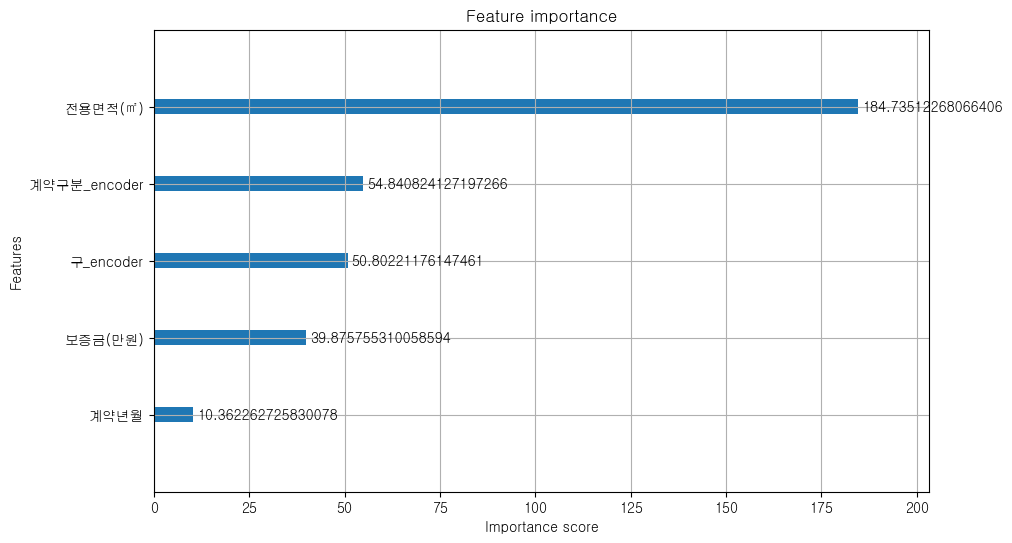

In [ ]:
# 특성중요도 시각화
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(10, 6))
plot_importance(xgb_clf, ax=ax, importance_type='gain')
plt.show()

In [ ]:
from lightgbm import LGBMClassifier
print('모델명 : LightGBM ---------------------')
lgbm = LGBMClassifier(
    n_estimators=400,
    learning_rate=0.7,
    early_stopping_rounds=100,
    verbose=1
)

eval_set = [(X_tr, y_tr), (X_eval, y_eval)]
lgbm.fit(X_tr, y_tr, eval_set=eval_set)

print('학습 데이터 점수 :', lgbm.score(X_train, y_train))
print('평가 데이터 점수 :', lgbm.score(X_test, y_test))

모델명 : LightGBM ---------------------
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Number of positive: 30797, number of negative: 67439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 551
[LightGBM] [Info] Number of data points in the train set: 98236, number of used features: 5
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.313500 -> initscore=-0.783806
[LightGBM] [Info] Start training from score -0.783806
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[51]	training's binary_logloss: 0.26